In [1]:
!pip install -q -U 'tensorflow-text==2.8.*'

     |████████████████████████████████| 4.9 MB 22.9 MB/s 
     |████████████████████████████████| 498.0 MB 12 kB/s 
     |████████████████████████████████| 1.4 MB 71.7 MB/s 
     |████████████████████████████████| 5.8 MB 55.6 MB/s 
     |████████████████████████████████| 462 kB 67.9 MB/s 


In [2]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.3 MB 36.3 MB/s 
     |████████████████████████████████| 5.8 MB 59.9 MB/s 
     |████████████████████████████████| 1.1 MB 50.6 MB/s 
     |████████████████████████████████| 588.3 MB 22 kB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 118 kB 69.9 MB/s 
     |████████████████████████████████| 662 kB 71.8 MB/s 
     |████████████████████████████████| 238 kB 75.5 MB/s 
     |████████████████████████████████| 38.2 MB 1.5 MB/s 
     |████████████████████████████████| 352 kB 69.2 MB/s 
     |████████████████████████████████| 1.3 MB 65.2 MB/s 
     |████████████████████████████████| 6.0 MB 65.7 MB/s 
     |████████████████████████████████| 1.7 MB 61.7 MB/s 
     |████████████████████████████████| 439 kB 63.2 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import re
import time
import unicodedata
import datetime
import pathlib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers

import tensorflow_hub as hub
import tensorflow_models as tfm

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
tf.get_logger().setLevel('ERROR')
tf.config.run_functions_eagerly(True)

### Variabili Globali

In [6]:
# PARAMETRI GLOBALI
root_folder = 'drive/MyDrive/BERT/'

# DATI
data_folder_name = 'data'
train_filename = 'ita.txt'

DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# PATH LOG Tensorboard
PATH_LOG = 'logs/fit/transformer_no_bert_v5'
PATH_LOG = os.path.abspath(os.path.join(root_folder, PATH_LOG))
log_dir =  os.path.abspath(os.path.join(PATH_LOG, datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))) 

# PATH WEIGHTS Tensorboard
PATH_WEIGHTS = 'weights/transformer_nobert_v5'
PATH_WEIGHTS = os.path.abspath(os.path.join(root_folder, PATH_WEIGHTS))

# MODELLO TOKENIZER
model_name = 'tokenizer_en_it_model'
tokenizer_folder_name = 'tokenizer'

TOKEN_PATH = os.path.abspath(os.path.join(root_folder, tokenizer_folder_name))
tokenizer_filenamepath = os.path.abspath(os.path.join(TOKEN_PATH, model_name))

In [7]:
# parametri per il modello
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 350000 # portato da 10.000 a 100.000
TRAIN = 16000

MAX_VOCAB_SIZE = 20000 # portato da 20.0000 a 200.000
EMBEDDING_DIM = 64  # --> 256  Densa non lineare relu --> 64  Densa non lineare relu (oppure Conv1D kernel=1)
HIDDEN_DIM = 256 # numero di celle nei layer ricorrenti nascosti

BATCH_SIZE = 32
BUFFER_SIZE = 2000
EPOCHS = 40
MAX_SEQ_LENGTH = 16

NUM_LAYERS = 1 # Numero di layer di Encoder e Decoder del Transformer
NUM_HEADS = 8 # Numero di meccanismi di multi-head attention
FF_DIM = 16 # Numero di celle dei Layer Feed Forward
DROPUOT = 0.5

LEARNING_RATE=0.01

# IMPOSTO IL DEBUG A TRUE 
debug = True
training = True

### Caricamento Dati

In [8]:
# Caricamento dataset: frasi in inglese, frasi in italiano
df = pd.read_csv(
    train_filenamepath,
    sep="\t",
    header=None,
    names=[INPUT_COLUMN, TARGET_COLUMN],
    usecols=[0,1],
    nrows=NUM_SAMPLES
)

df = df[-20800:]

print(df.iloc[-4:], '\n')

# Preprocessing dei dati di Input
input_data = df[INPUT_COLUMN].tolist()

# Preprocessing dei dati Target con aggiunta del token di fine frase
target_data = df[TARGET_COLUMN].tolist()

train_input_data = input_data[:TRAIN]
train_target_data = target_data[:TRAIN]

test_input_data = input_data[TRAIN:]
test_target_data = target_data[TRAIN:]

print('-----------TRAIN SET--------------')
print(train_input_data[-4:])
print(train_target_data[-4:])
print('-----------TEST SET---------------')
print(test_input_data[-4:])
print(test_target_data[-4:])


                                                    input  \
349996  You cannot achieve the impossible without atte...   
349997  You cannot achieve the impossible without atte...   
349998  You cannot achieve the impossible without atte...   
349999  You cannot achieve the impossible without atte...   

                                                   target  
349996  Non puoi raggiungere l'impossibile senza tenta...  
349997  Non può raggiungere l'impossibile senza tentar...  
349998  Non si può raggiungere l'impossibile senza ten...  
349999  Non potete raggiungere l'impossibile senza ten...   

-----------TRAIN SET--------------
['Tom always makes fun of John because of his dialect.', 'Tom and Mary always play tennis on Saturday morning.', 'Tom and Mary always seem to be hanging out together.', "Tom and Mary are both quite overweight, aren't they?"]
['Tom prende sempre in giro John per via del suo dialetto.', 'Tom e Mary giocano sempre a tennis al sabato mattina.', 'Tom e Mary se

### Tokenizer

Carico il modello di tokenizer creato utilizzzando il set di dati a disposizione

In [9]:
tokenizers = tf.saved_model.load(tokenizer_filenamepath)

In [10]:
print(input_data[-2:])
print(tokenizers.en.tokenize(input_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.en.tokenize(input_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.en.detokenize(tokenizers.en.tokenize(input_data[-2:])))
print('------------------------------------------------------------------')
print(target_data[-2:])
print(tokenizers.it.tokenize(target_data[-2:]))
print(keras.preprocessing.sequence.pad_sequences(tokenizers.it.tokenize(target_data[-2:]).numpy(), maxlen=MAX_SEQ_LENGTH, padding='post'))
print(tokenizers.it.detokenize(tokenizers.it.tokenize(target_data[-2:])))

['You cannot achieve the impossible without attempting the absurd.', 'You cannot achieve the impossible without attempting the absurd.']
<tf.RaggedTensor [[2, 55, 735, 26, 2134, 4260, 58, 1064, 320, 3531, 322, 58, 2428, 11, 3],
 [2, 55, 735, 26, 2134, 4260, 58, 1064, 320, 3531, 322, 58, 2428, 11, 3]]>
[[   2   55  735   26 2134 4260   58 1064  320 3531  322   58 2428   11
     3    0]
 [   2   55  735   26 2134 4260   58 1064  320 3531  322   58 2428   11
     3    0]]
tf.Tensor(
[b'you cannot achieve the impossible without attempting the absurd .'
 b'you cannot achieve the impossible without attempting the absurd .'], shape=(2,), dtype=string)
------------------------------------------------------------------
["Non si può raggiungere l'impossibile senza tentare l'assurdo.", "Non potete raggiungere l'impossibile senza tentare l'assurdo."]
<tf.RaggedTensor [[2, 56, 78, 153, 2118, 37, 8, 1264, 255, 9231, 37, 8, 4359, 11, 3],
 [2, 56, 325, 2118, 37, 8, 1264, 255, 9231, 37, 8, 4359, 11, 3]

### Creazione dataset
Utilizzo della libreria tf.data per la gestione del dataset da utilizzare.
Verranno creati batch di esempi che verranno utilizzati durante l'addestramento.

In [11]:
def prepare_batch(en, it):
  zero = tf.zeros([BATCH_SIZE, MAX_SEQ_LENGTH], tf.int64)
  en = tokenizers.en.tokenize(en) # Output is ragged.
  en = tf.concat([en, zero], 1)
  en = en[:, :MAX_SEQ_LENGTH]     # Trim to MAX_TOKENS.
  en = en.to_tensor()             # Convert to 0-padded dense Tensor

  it = tokenizers.it.tokenize(it)
  it_inputs = it[:, :-1].to_tensor()  # Drop the [END] tokens
  it_labels = it[:, 1:].to_tensor()   # Drop the [START] tokens
  
  it_inputs = tf.concat([it_inputs, zero], 1)
  it_inputs = it_inputs[:, :(MAX_SEQ_LENGTH)]

  it_labels = tf.concat([it_labels, zero], 1)
  it_labels = it_labels[:, :(MAX_SEQ_LENGTH)]

  return (en, it_inputs), it_labels

In [12]:
def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

In [13]:
# Definizione del dataset
# [from_tensor_slices] permette di recuperare batch
# di esempi dai dataset di riferimento
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_target_data))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input_data, test_target_data))

# impostazione del recupero di esempi presi in maniera
# casuale in gruppi di [BATCH_SIZE] tra quelli disponibili
train_dataset = make_batches(train_dataset)
test_dataset = make_batches(test_dataset)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [14]:
# Recupero un batch di esempi per la verifica delle classi custom che andrò a creare
for (en_input, it_input), it_target in train_dataset.take(1):
  print(f'Shape en input           : {en_input.shape}')
  print(f'Example en input         : {en_input[0]}')  
  print('-------------------------------------------------------')
  print(f'Shape it input           : {it_input.shape}')
  print(f'Example it input         : {it_input[0]}')  
  print(f'Shape it input           : {it_target.shape}')
  print(f'Example it target        : {it_target[0]}')  

Shape en input           : (32, 16)
Example en input         : [   2   56  107    8   45 1598   57  846 4291  349   11    3    0    0
    0    0]
-------------------------------------------------------
Shape it input           : (32, 16)
Example it input         : [   2   55   56   30 1088   26  866 8571   11    0    0    0    0    0
    0    0]
Shape it input           : (32, 16)
Example it target        : [  55   56   30 1088   26  866 8571   11    3    0    0    0    0    0
    0    0]


### Token and Position Embedding

Implementazione del blocco Embedding per l'utilizzo di vettori posizionali insieme ai vettori di token di parole tramite estensione della classe Layer di Keras

In [15]:
class TokenAndPositionEmbedding(layers.Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.maxlen = maxlen
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x, debug=False):
    x = keras.preprocessing.sequence.pad_sequences(x, maxlen=self.maxlen, padding='post')
    maxlen = tf.shape(x)[-1]

    if debug:
      print('********** DEBUG TOKEN AND POSITION EMBEDDING ***********')
      print(f'Sequence Max len                          : {maxlen}')
      print(f'Sequence Shape                            : {tf.shape(x)}')

    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    output = x + positions

    if debug:
      print(f'Shape TokenAndPositionEmbedding           : {output.shape}')
      print('*********************************************************')

    return output

In [16]:
token_position_en = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.en.get_vocab_size(), EMBEDDING_DIM)
token_position_it = TokenAndPositionEmbedding(MAX_SEQ_LENGTH, tokenizers.it.get_vocab_size(), EMBEDDING_DIM)

inputs_encoder = token_position_en(en_input, debug)
inputs_decoder = token_position_it(it_input, debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 16
Sequence Shape                            : [32 16]
Shape TokenAndPositionEmbedding           : (32, 16, 64)
*********************************************************
********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 16
Sequence Shape                            : [32 16]
Shape TokenAndPositionEmbedding           : (32, 16, 64)
*********************************************************


### Encoder

Implmentazione di un blocco di EncoderTransformer tramite estensione della classe Layer di Keras

In [17]:
class Encoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='ENC'):
    super(Encoder, self).__init__()
    self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, training=False, debug=False):
    attn_output = self.att(query=inputs,
                           value=inputs, 
                           key=inputs)
    
    attn_output = self.dropout1(attn_output)
    out1 = self.layernorm1(inputs + attn_output)

    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)

    output = self.layernorm2(out1 + ffn_output)

    if debug:
      print('********************* DEBUG ENCODER *********************')
      print(f'Shape Input Layer Encoder       : {inputs.shape}')
      print(f'Shape Output Layer Encoder      : {output.shape}')
      print('*********************************************************')

    return output

In [18]:
encoder = Encoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_encoder = encoder(inputs=inputs_encoder,
                          training=training, 
                          debug=debug)

********************* DEBUG ENCODER *********************
Shape Input Layer Encoder       : (32, 16, 64)
Shape Output Layer Encoder      : (32, 16, 64)
*********************************************************


### Decoder

Implementazione di un blocco di DecoderTransformer tramite estensione della classe Layer di Keras

In [19]:
class Decoder(layers.Layer):
  def __init__(self, max_len, embed_dim, num_heads, ff_dim, rate=0.5, name='DEC'):
    super(Decoder, self).__init__()
    self.att1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.att2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = keras.Sequential(
      [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim),]
    )
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()
    self.layernorm3 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)
    self._name = name

  def call(self, inputs, encoder_output, training=False, debug=False):
    attn_output1 = self.att1(query=inputs,
                             value=inputs, 
                             key=inputs, 
                             use_causal_mask=True)
    
    attn_output1 = self.dropout1(attn_output1)
    out1 = self.layernorm1(inputs + attn_output1)

    attn_output2 = self.att2(key=encoder_output, 
                             value=encoder_output, 
                             query=out1)
    
    attn_output2 = self.dropout2(attn_output2, training=training)
    out2 = self.layernorm2(out1 + attn_output2)

    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)

    output = self.layernorm3(out2 + ffn_output)

    if debug:
      print('******************* DEBUG DECODER ***********************')
      print(f'Input Shape                       : {inputs.shape}')
      print(f'Shape Outputs Decoder             : {output.shape}')
      print('*********************************************************')

    return output

In [20]:
decoder = Decoder(MAX_SEQ_LENGTH, 
                  EMBEDDING_DIM, 
                  NUM_HEADS, 
                  FF_DIM, 
                  DROPUOT)

outputs_decoder = decoder(inputs=inputs_decoder, 
                          encoder_output=outputs_encoder,  
                          training=training,
                          debug=debug)

******************* DEBUG DECODER ***********************
Input Shape                       : (32, 16, 64)
Shape Outputs Decoder             : (32, 16, 64)
*********************************************************


### Transformer

Implementazione del blocco Transformer tramite estensione della classe Layer di Keras

In [21]:
class TransformerBlock(keras.Model):
  def __init__(self, 
               num_layers, 
               embed_dim, 
               num_heads, 
               ff_dim, 
               max_len,
               input_vocab_size,
               target_vocab_size,
               rate=0.5):
    
    super(TransformerBlock, self).__init__()

    self.num_layers = num_layers

    self.token_pos_enc = TokenAndPositionEmbedding(max_len, input_vocab_size, embed_dim)
    self.token_pos_dec = TokenAndPositionEmbedding(max_len, target_vocab_size, embed_dim)

    self.encoder = [Encoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
    self.decoder = [Decoder(max_len, embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

    self.dropout = layers.Dropout(rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training=False, debug=False):
    inputs_encoder, inputs_decoder  = inputs

    inputs_encoder = self.token_pos_enc(inputs_encoder, debug)
    inputs_decoder = self.token_pos_dec(inputs_decoder, debug)

    if debug:
      print(f'---------------- DEBUG TRANSFORMER BLOCK ----------------')
      print(f'inputs_encoder       : {inputs_encoder.shape}')
      print(f'inputs_decoder       : {inputs_decoder.shape}')      

    encoder_output = inputs_encoder
    transformer_output = inputs_decoder

    for i in range(self.num_layers):
      encoder_output = self.encoder[i](inputs=encoder_output, 
                                       training=training, 
                                       debug=debug) 
      
    for i in range(self.num_layers):
      transformer_output = self.decoder[i](inputs=transformer_output, 
                                           encoder_output=encoder_output, 
                                           training=training,
                                           debug=debug)

    transformer_output = self.dropout(transformer_output)
    logits = self.final_layer(transformer_output)

    if debug:
      print(f'Output Shape       : {logits.shape}')
      print(f'Output Transformer : {logits[0, :1, :12]}')    
      print(f'---------------------------------------------------------')

    return logits

In [22]:
transformer = TransformerBlock(NUM_LAYERS, 
                               EMBEDDING_DIM, 
                               NUM_HEADS, 
                               FF_DIM,
                               MAX_SEQ_LENGTH,
                               tokenizers.en.get_vocab_size(),
                               tokenizers.it.get_vocab_size(),
                               DROPUOT)

transformer_output = transformer((en_input, it_input), 
                                 training=training,
                                 debug=debug)

********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 16
Sequence Shape                            : [32 16]
Shape TokenAndPositionEmbedding           : (32, 16, 64)
*********************************************************
********** DEBUG TOKEN AND POSITION EMBEDDING ***********
Sequence Max len                          : 16
Sequence Shape                            : [32 16]
Shape TokenAndPositionEmbedding           : (32, 16, 64)
*********************************************************
---------------- DEBUG TRANSFORMER BLOCK ----------------
inputs_encoder       : (32, 16, 64)
inputs_decoder       : (32, 16, 64)
********************* DEBUG ENCODER *********************
Shape Input Layer Encoder       : (32, 16, 64)
Shape Output Layer Encoder      : (32, 16, 64)
*********************************************************
******************* DEBUG DECODER ***********************
Input Shape                       : (32, 16, 64)
Shape Out

In [23]:
transformer.summary()

Model: "transformer_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  multiple                 394688    
 g_2 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 token_and_position_embeddin  multiple                 594816    
 g_3 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 ENC (Encoder)               multiple                  135056    
                                                                 
 DEC (Decoder)               multiple                  267856    
                                                                 
 dropout_13 (Dropout)        multiple            

### Addestramento

In [ ]:
import json

learning_rate = [1e-4, 3e-4]
beta_1 = [0.9, 0.99]
beta_2 = [0.98, 0.75, 0.66]

for lr in learning_rate:
  for b1 in beta_1:
    for b2 in beta_2:
      transformer = TransformerBlock(NUM_LAYERS, 
                                EMBEDDING_DIM, 
                                NUM_HEADS, 
                                FF_DIM,
                                MAX_SEQ_LENGTH,
                                tokenizers.en.get_vocab_size(),
                                tokenizers.it.get_vocab_size(),
                                DROPUOT)

      transformer.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=lr, beta_1=b1, beta_2=b2, epsilon=1e-9),
                          metrics=[keras.metrics.SparseCategoricalAccuracy()])

      path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp_lr_' + str(lr) + '_b1_' + str(b1) + '_b2_' + str(b2)))

      json_log  = open(PATH_LOG + '/train_log_AdamW_lr_' + str(lr) + '_b1_' + str(b1) + '_b2_' + str(b2) + '.json', mode='wt', buffering=1)

      print('Parametri Addestramento AdamW : lr=' + str(lr) + ', b1=' + str(b1) + ', b2=' + str(b2))   
      json_logging_callback = tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: json_log.write(
          json.dumps({'epoch': epoch, 
                      'loss': logs['loss'],
                      'sparse_categorical_accuracy': logs['sparse_categorical_accuracy'],
                      'val_loss': logs['val_loss'],
                      'val_sparse_categorical_accuracy': logs['val_sparse_categorical_accuracy']}) + '\n'),
        on_train_end=lambda logs: json_log.close()
      )

      # Create a callback that saves the model's weights
      checkpoint_path = os.path.abspath(os.path.join(path, 'cp.ckpt'))
      cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=True)

      start = datetime.datetime.now()
      history = transformer.fit(train_dataset,
                                initial_epoch=0,
                                epochs=3,
                                shuffle=True,
                                validation_data=test_dataset,
                                callbacks=[json_logging_callback,
                                            cp_callback])

      '''
      lr_sgd = lr - (lr * 0.03) # Abbasso il learning rate di un 30%
      json_log  = open(PATH_LOG + '/train_log_SGD_lr_' + str(lr) + '_b1_' + str(b1) + '_b2_' + str(b2) + '.json', mode='wt', buffering=1)

      transformer.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          optimizer=tf.keras.optimizers.SGD(learning_rate=lr_sgd),
                          metrics=[keras.metrics.SparseCategoricalAccuracy()])

      latest = tf.train.latest_checkpoint(path)
      transformer.load_weights(latest)
      print('\nParametri Addestramento SGD : lr=' + str(lr_sgd) + ', b1=' + str(b1) + ', b2=' + str(b2))   

      history += transformer.fit(train_dataset,
                                initial_epoch=7,
                                epochs=10,
                                shuffle=True,
                                validation_data=test_dataset,
                                callbacks=[json_logging_callback,
                                            cp_callback])
      '''
      end = datetime.datetime.now()
      print(f'Tempo necessario per l\'addestramento: {end - start}')


Parametri Addestramento AdamW : lr=0.0001, b1=0.9, b2=0.98
Epoch 1/3
500/500 [==============================] - 216s 432ms/step - loss: 7.3558 - sparse_categorical_accuracy: 0.2502 - val_loss: 6.1808 - val_sparse_categorical_accuracy: 0.1461
Epoch 2/3
500/500 [==============================] - 215s 431ms/step - loss: 5.0715 - sparse_categorical_accuracy: 0.2875 - val_loss: 5.4022 - val_sparse_categorical_accuracy: 0.1989
Epoch 3/3
500/500 [==============================] - 215s 430ms/step - loss: 4.3165 - sparse_categorical_accuracy: 0.3692 - val_loss: 5.0143 - val_sparse_categorical_accuracy: 0.2790
Tempo necessario per l'addestramento: 0:11:35.468192
Parametri Addestramento AdamW : lr=0.0001, b1=0.9, b2=0.75
Epoch 1/3
500/500 [==============================] - 194s 388ms/step - loss: 7.3454 - sparse_categorical_accuracy: 0.2677 - val_loss: 6.0628 - val_sparse_categorical_accuracy: 0.1542
Epoch 2/3
500/500 [==============================] - 194s 388ms/step - loss: 4.8684 - sparse_cate

### Addestramento AdamW + SGD

In [25]:
import json

learning_rate = [3e-4]
beta_1 = [0.9]
beta_2 = [0.98, 0.75]

for lr in learning_rate:
  for b1 in beta_1:
    for b2 in beta_2:
      transformer = TransformerBlock(NUM_LAYERS, 
                                EMBEDDING_DIM, 
                                NUM_HEADS, 
                                FF_DIM,
                                MAX_SEQ_LENGTH,
                                tokenizers.en.get_vocab_size(),
                                tokenizers.it.get_vocab_size(),
                                DROPUOT)

      transformer.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=lr, beta_1=b1, beta_2=b2, epsilon=1e-9),
                          metrics=[keras.metrics.SparseCategoricalAccuracy()])

      path = os.path.abspath(os.path.join(PATH_WEIGHTS, 'cp_lr_' + str(lr) + '_b1_' + str(b1) + '_b2_' + str(b2)))

      json_log  = open(PATH_LOG + '/train_log_AdamW_lr_' + str(lr) + '_b1_' + str(b1) + '_b2_' + str(b2) + '.json', mode='wt', buffering=1)

      print('\nParametri Addestramento AdamW : lr=' + str(lr) + ', b1=' + str(b1) + ', b2=' + str(b2))   
      json_logging_callback = tf.keras.callbacks.LambdaCallback(
        on_epoch_end=lambda epoch, logs: json_log.write(
          json.dumps({'epoch': epoch, 
                      'loss': logs['loss'],
                      'sparse_categorical_accuracy': logs['sparse_categorical_accuracy'],
                      'val_loss': logs['val_loss'],
                      'val_sparse_categorical_accuracy': logs['val_sparse_categorical_accuracy']}) + '\n'),
        on_train_end=lambda logs: json_log.close()
      )

      # Create a callback that saves the model's weights
      checkpoint_path = os.path.abspath(os.path.join(path, 'cp.ckpt'))
      cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        save_weights_only=True,
                                                        save_best_only=True)

      start = datetime.datetime.now()
      history = transformer.fit(train_dataset,
                                initial_epoch=0,
                                epochs=7,
                                shuffle=True,
                                validation_data=test_dataset,
                                callbacks=[json_logging_callback,
                                            cp_callback])

      lr_sgd = 1e-4
      json_log  = open(PATH_LOG + '/train_log_SGD_lr_' + str(lr_sgd) + '.json', mode='wt', buffering=1)

      transformer.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          optimizer=tf.keras.optimizers.SGD(learning_rate=lr_sgd),
                          metrics=[keras.metrics.SparseCategoricalAccuracy()])

      latest = tf.train.latest_checkpoint(path)
      transformer.load_weights(latest)
      print('\nParametri Addestramento SGD : lr=' + str(lr_sgd))   

      history = transformer.fit(train_dataset,
                                initial_epoch=7,
                                epochs=12,
                                shuffle=True,
                                validation_data=test_dataset,
                                callbacks=[json_logging_callback,
                                            cp_callback])
      
      end = datetime.datetime.now()
      print(f'Tempo necessario per l\'addestramento: {end - start}')


Parametri Addestramento AdamW : lr=0.0003, b1=0.9, b2=0.98
Epoch 1/7
500/500 [==============================] - 172s 344ms/step - loss: 5.6724 - sparse_categorical_accuracy: 0.2997 - val_loss: 5.0559 - val_sparse_categorical_accuracy: 0.2696
Epoch 2/7
500/500 [==============================] - 176s 352ms/step - loss: 3.8800 - sparse_categorical_accuracy: 0.4289 - val_loss: 4.6160 - val_sparse_categorical_accuracy: 0.3280
Epoch 3/7
500/500 [==============================] - 174s 347ms/step - loss: 3.5141 - sparse_categorical_accuracy: 0.4650 - val_loss: 4.3886 - val_sparse_categorical_accuracy: 0.3544
Epoch 4/7
500/500 [==============================] - 172s 344ms/step - loss: 3.2798 - sparse_categorical_accuracy: 0.4917 - val_loss: 4.2061 - val_sparse_categorical_accuracy: 0.3777
Epoch 5/7
500/500 [==============================] - 178s 355ms/step - loss: 3.1080 - sparse_categorical_accuracy: 0.5111 - val_loss: 4.1036 - val_sparse_categorical_accuracy: 0.3939
Epoch 6/7
500/500 [=======

### Valutazione dell'addestramento
Avendo in output il log ed i risultati dell'addestramento, possiamo visualizzare
queste informazioni relativamente alle metriche di interesse.

In [ ]:
# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(history.history['loss'], label='Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(history.history['sparse_categorical_accuracy'], label='Accuracy')
ax2.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

## Addestramento 2

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
start = datetime.datetime.now()
history = transformer.fit(train_dataset,
                          epochs=EPOCHS+EPOCHS,
                          initial_epoch=EPOCHS,
                          shuffle=True,
                          validation_data=test_dataset,
                          callbacks=[tensorboard_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 51/100
500/500 [==============================] - 166s 331ms/step - loss: 2.1910 - sparse_categorical_accuracy: 0.6185 - val_loss: 2.6461 - val_sparse_categorical_accuracy: 0.6264
Epoch 52/100
500/500 [==============================] - 164s 329ms/step - loss: 2.1958 - sparse_categorical_accuracy: 0.6177 - val_loss: 2.6386 - val_sparse_categorical_accuracy: 0.6255
Epoch 53/100
500/500 [==============================] - 162s 325ms/step - loss: 2.1880 - sparse_categorical_accuracy: 0.6199 - val_loss: 2.6518 - val_sparse_categorical_accuracy: 0.6286
Epoch 54/100
500/500 [==============================] - 161s 322ms/step - loss: 2.1845 - sparse_categorical_accuracy: 0.6189 - val_loss: 2.6390 - val_sparse_categorical_accuracy: 0.6279
Epoch 55/100
500/500 [==============================] - 163s 326ms/step - loss: 2.1789 - sparse_categorical_accuracy: 0.6193 - val_loss: 2.6250 - val_sparse_categorical_accuracy: 0.6302
Epoch 56/100
500/500 [==============================] - 163s 326ms/ste

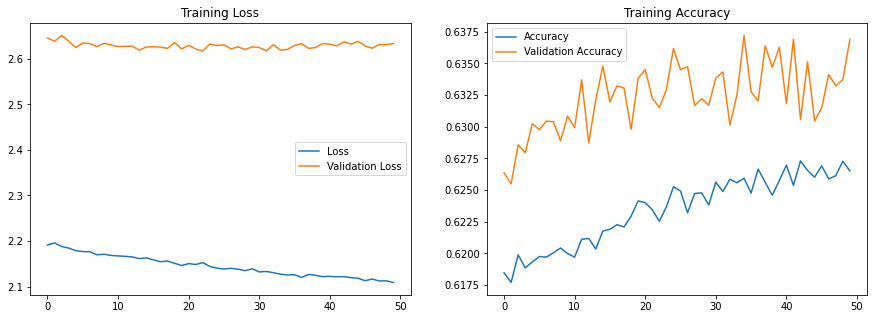

In [ ]:
# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(history.history['loss'], label='Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(history.history['sparse_categorical_accuracy'], label='Accuracy')
ax2.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

## Addestramento 3

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
transformer.compile(
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
start = datetime.datetime.now()
history = transformer.fit(train_dataset,
                          epochs=EPOCHS+EPOCHS+EPOCHS,
                          initial_epoch=EPOCHS+EPOCHS,
                          shuffle=True,
                          validation_data=test_dataset,
                          callbacks=[tensorboard_callback, 
                                     cp_callback])

end = datetime.datetime.now()
print(f'Tempo necessario per l\'addestramento: {end - start}')

Epoch 101/150
500/500 [==============================] - 164s 328ms/step - loss: 2.3428 - sparse_categorical_accuracy: 0.6180 - val_loss: 2.6914 - val_sparse_categorical_accuracy: 0.6249
Epoch 102/150
500/500 [==============================] - 164s 329ms/step - loss: 2.2985 - sparse_categorical_accuracy: 0.6173 - val_loss: 2.6685 - val_sparse_categorical_accuracy: 0.6213
Epoch 103/150
500/500 [==============================] - 163s 327ms/step - loss: 2.2677 - sparse_categorical_accuracy: 0.6191 - val_loss: 2.6364 - val_sparse_categorical_accuracy: 0.6213
Epoch 104/150
500/500 [==============================] - 162s 323ms/step - loss: 2.2492 - sparse_categorical_accuracy: 0.6187 - val_loss: 2.6334 - val_sparse_categorical_accuracy: 0.6200
Epoch 105/150
500/500 [==============================] - 161s 322ms/step - loss: 2.2322 - sparse_categorical_accuracy: 0.6199 - val_loss: 2.6283 - val_sparse_categorical_accuracy: 0.6187
Epoch 106/150
500/500 [==============================] - 160s 320

In [ ]:
# visualizzazione andamento addestramento
# su un grafico composto da due sub-plot
# uno per il loss, l'altro per l'accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Errore durante l'addestramento
ax1.plot(history.history['loss'], label='Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training Loss')
ax1.legend()

# Accuratezza durante l'addestramento
ax2.plot(history.history['sparse_categorical_accuracy'], label='Accuracy')
ax2.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training Accuracy')
ax2.legend()

plt.show()

## Test del modello
La seguente cella permette di caricare l'ultimo checkpoint dell'addestramento
precedentemente salvato.

In [ ]:
# Carico i pesi modello
latest = tf.train.latest_checkpoint(PATH_WEIGHTS)
transformer.load_weights(latest)

In [ ]:
class Translate:
  def __init__(self, transformer_block, tokenizers):
    self.transformer = transformer_block
    self.tokenizers = tokenizers

  def predict(self, input_text, max_length):
    if input_text is None:
      input_text = input_data[np.random.choice(len(input_data))]
      print(input_text)

    # print(input_text)
    inputs_encoder = self.tokenizers.en.tokenize(input_text).to_tensor()
    inputs_encoder = keras.preprocessing.sequence.pad_sequences(inputs_encoder, maxlen=max_length, padding='post')

    # print(inputs_encoder)
    
    start_end = self.tokenizers.it.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = (start_end[1][tf.newaxis]).numpy()[0]

    output_array = tf.TensorArray(dtype=tf.int64, size=max_length, dynamic_size=True)
    output_array = output_array.write(0, start)     

    out_words = []

    for i in tf.range(max_length):
      # decodifica e recupero probabilità di output
      output = tf.transpose(output_array.stack())
      # print('Output', output)
      transformer_output = transformer([inputs_encoder, output], 
                                        training=False,
                                        debug=False)

      predictions = transformer_output[:, -1:, :]

      # selezione della parola più probabile
      predict = tf.argmax(predictions, -1)
      pred_values = (K.argmax(transformer_output, axis=-1)).numpy()
      # preds = pred_values[0][predict.numpy()[0][0]]
      
      # print('predict',  predict)
      # print('predictions', transformer_output)
      # print('pred_values', pred_values[0][0])
      # print('predict[0]', pred_values[0][i])
      
  
      # print('Preds', preds)
      # print('Detokenize', (tokenizers.it.detokenize(pred_values)))
      # print('##########################')
    
      # inserimento della parola nella sequenza di output
      output_array = output_array.write(i+1, [pred_values[0][i]])
      # output_array = output_array.write(i+1, predict[0])

      # termine del ciclo quando si incontra il token <end-of-sentence>
      # oppure la lunghezza massima prevista della sequenza
      # print(end)
      if pred_values[0][i] == end:
        break

    output = tf.transpose(output_array.stack())
    text = tokenizers.it.detokenize(output)[0]  

    tokens = tokenizers.it.lookup(output)[0]

    return text, tokens

In [ ]:
test_sequences = [test_input_data[41], test_input_data[182], test_input_data[612], test_input_data[432], test_input_data[222]]

translate = Translate(transformer_block=transformer,
                      tokenizers=tokenizers)

for test_sequence in test_sequences:
  text, token = translate.predict(tf.constant([test_sequence]), MAX_SEQ_LENGTH)

  print(f'{"Input:":15s}: {test_sequence}')
  print(f'{"Prediction":15s}: {text.numpy().decode("utf-8")}')  
  # print(f'tokens : {token}')
  # print(target_data[41])
  # break
  print('---------------------------------------------')

print(test_target_data[41])
print(test_target_data[102])
print(test_target_data[612])
print(test_target_data[432])
print(test_target_data[222])

## Tensorboard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
log_dir

In [ ]:
%tensorboard --logdir drive/MyDrive/BERT/logs/fit/20221026-134720